In [1]:
import os
import json
import numpy as np

In [2]:
results_root = '../../results/planning/igibson/official_run_no_cot/vila'
splits = ['simple','medium','hard']

exp_paths = {}
for split in splits:
    results_path = os.path.join(results_root,split)
    exp_paths[split] = [os.path.join(results_path,d) for d in os.listdir(results_path) if not '.ipynb_checkpoints' in d]
exp_paths

{'simple': ['../../results/planning/igibson/official_run_no_cot/vila/simple/InternVL3-8B',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/gemma-3-12b-it',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/gemma-3-27b-it',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/llava-onevision-qwen2-7b-ov-hf',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/Qwen2.5-VL-72B-Instruct',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/aya-vision-32b',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/Phi-4-multimodal-instruct',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/Qwen2.5-VL-7B-Instruct',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/deepseek-vl2',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/aya-vision-8b',
  '../../results/planning/igibson/official_run_no_cot/vila/simple/Molmo-7B-D-0924',
  '../../results/planning/igibson/off

In [3]:
 # user specified, just the main job id without the array job suffices -> why all jobs have different slurm ids???
#runs_ids = ['7157692','7157903','7158205', '7159268', '7159742', '7165833', '7169514', '7171078']
runs_ids = [
    '7174751', # main run big models
    '7174752', # main run small models
    #'7181135', # DeepseekVL recovery run - apparently not needed
    '7181137', # Aya 32B recovery run
    '7181189', # InvernVL 78B recovery run
    '7183701'  # InvernVL 78B recovery run
]
all_results = {}
main_results = {}
for split in exp_paths.keys():
    all_results[split] = {}
    main_results[split] = {}
    
    for exp_dir in exp_paths[split]: # List[str]
        # Look for json with id within runs_ids
        exp_results_json_name = [
            os.path.join(exp_dir,f) for f in os.listdir(exp_dir) if np.any([run_id in f for run_id in runs_ids])
        ]
        if len(exp_results_json_name)==1:
            # extract json
            with open(exp_results_json_name[0]) as f:
                exp_results_json = json.load(f)
            #print(exp_results_json['statistics'])
            model_name = exp_results_json['metadata']['model']
            all_results[split][model_name] = exp_results_json
            main_results[split][model_name] = {k:exp_results_json['statistics'][k] for k in ['action_success_rate', 'task_completion_rate']}
            
        elif len(exp_results_json_name)>1:
            print(f"More than 1 runs_ids matching for {exp_dir} - skip")
            
        elif len(exp_results_json_name)==0:
            print(f"No runs_ids matching for {exp_dir} - skip")
            
        else:
            raise NotImplementedError  

print(main_results)

{'simple': {'OpenGVLab/InternVL3-8B': {'action_success_rate': 0.8956521739130435, 'task_completion_rate': 0.16}, 'google/gemma-3-12b-it': {'action_success_rate': 0.6417112299465241, 'task_completion_rate': 0.64}, 'google/gemma-3-27b-it': {'action_success_rate': 0.900709219858156, 'task_completion_rate': 0.92}, 'llava-hf/llava-onevision-qwen2-7b-ov-hf': {'action_success_rate': 0, 'task_completion_rate': 0.0}, 'Qwen/Qwen2.5-VL-72B-Instruct': {'action_success_rate': 0.8448275862068966, 'task_completion_rate': 0.68}, 'CohereLabs/aya-vision-32b': {'action_success_rate': 0.6048387096774194, 'task_completion_rate': 0.36}, 'microsoft/Phi-4-multimodal-instruct': {'action_success_rate': 1.0, 'task_completion_rate': 0.0}, 'Qwen/Qwen2.5-VL-7B-Instruct': {'action_success_rate': 0.6223175965665236, 'task_completion_rate': 0.16}, 'deepseek-ai/deepseek-vl2': {'action_success_rate': 0.9047619047619048, 'task_completion_rate': 0.0}, 'CohereLabs/aya-vision-8b': {'action_success_rate': 0.2757009345794392,

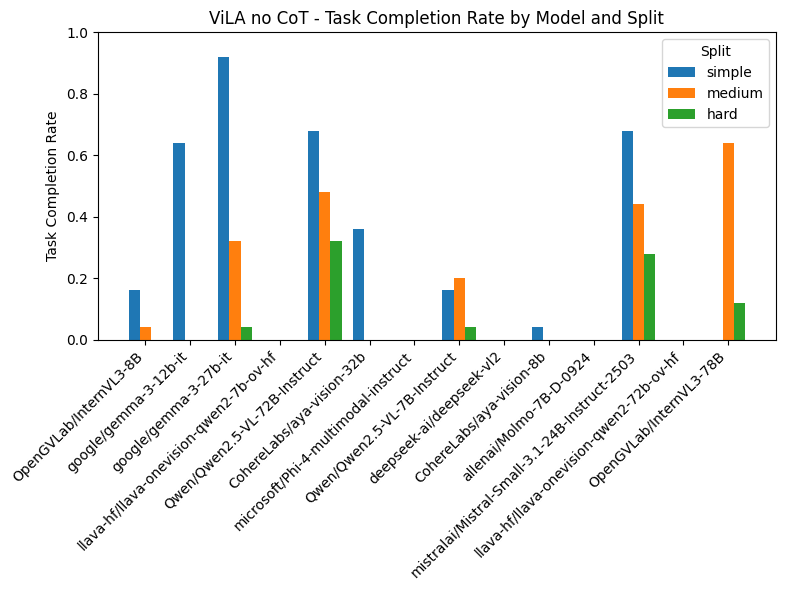

In [4]:
import numpy as np
import matplotlib.pyplot as plt

splits = list(main_results.keys())
models = list(next(iter(main_results.values())).keys())
if 'OpenGVLab/InternVL3-78B' not in models:
    models.append('OpenGVLab/InternVL3-78B')
    
x = np.arange(len(models))               # the “center” of each group
width = 0.25                              # width of each bar
n_splits = len(splits)

# total width of all bars in a group
total_width = width * n_splits
# amount to shift the leftmost bar so that the group is centred at x
shift = total_width/2 - width/2

fig, ax = plt.subplots(figsize=(8, 6))

for i, split in enumerate(splits):
    # calculate the offsets so bars span [x – shift … x + shift]
    offsets = x - shift + i * width
    rates = [
        main_results[split][model]["task_completion_rate"] if model in main_results[split].keys() else 0 
        for model in models
    ]
    ax.bar(offsets, rates, width, label=split, align='center')

# Formatting
ax.set_ylabel('Task Completion Rate')
#ax.set_xlabel('Model')
ax.set_title('ViLA no CoT - Task Completion Rate by Model and Split')

# place ticks at the group centers,
# rotate and right-align the labels
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right')

ax.set_ylim(0, 1)  # assuming rates between 0 and 1
ax.legend(title='Split')
plt.tight_layout()
plt.show()


In [5]:
from tabulate import tabulate

models = list(next(iter(main_results.values())).keys())
if 'OpenGVLab/InternVL3-78B' not in models:
    models.append('OpenGVLab/InternVL3-78B')
    
metric = "task_completion_rate"
# Create a list of rows for tabulate
rows = []
for model in models:
    row = [model]
    for split in main_results.keys():
        entry = [f"{main_results[split][model][metric]:.2f}" if model in main_results[split].keys() else 'N/A']
        row += entry
    rows.append(row)

sorted_rows = sorted(rows, key=lambda row: float(row[1]) if row[1] != 'N/A' else -np.inf, reverse=True)

# Print in tabular form
print(tabulate(sorted_rows, headers=["Model", "Simple", "Medium", "Hard"], floatfmt=".2f"))

Model                                          Simple      Medium    Hard
---------------------------------------------  --------  --------  ------
google/gemma-3-27b-it                          0.92          0.32    0.04
Qwen/Qwen2.5-VL-72B-Instruct                   0.68          0.48    0.32
mistralai/Mistral-Small-3.1-24B-Instruct-2503  0.68          0.44    0.28
google/gemma-3-12b-it                          0.64          0.00    0.00
CohereLabs/aya-vision-32b                      0.36          0.00    0.00
OpenGVLab/InternVL3-8B                         0.16          0.04    0.00
Qwen/Qwen2.5-VL-7B-Instruct                    0.16          0.20    0.04
CohereLabs/aya-vision-8b                       0.04          0.00    0.00
llava-hf/llava-onevision-qwen2-7b-ov-hf        0.00          0.00    0.00
microsoft/Phi-4-multimodal-instruct            0.00          0.00    0.00
deepseek-ai/deepseek-vl2                       0.00          0.00    0.00
allenai/Molmo-7B-D-0924               

In [6]:
from collections import defaultdict

def aggregate_global_success(all_results):
    global_counts = defaultdict(lambda: {'success': 0, 'total': 0})

    for split, split_data in all_results.items():
        for model, model_data in split_data.items():
            for task, task_data in model_data.items():
                actions = task_data.get('actions', [])
                for entry in actions:
                    name = entry['action'].split('(')[0].replace('-', '_')
                    global_counts[name]['total'] += 1
                    if entry.get('success'):
                        global_counts[name]['success'] += 1

    # Build final metrics
    global_metrics = {}
    for name, counts in global_counts.items():
        s = counts['success']
        t = counts['total']
        global_metrics[name] = (s, t, s / t if t else 0.0)
    return global_metrics

In [7]:
global_legals = aggregate_global_success(all_results)

In [8]:
from collections import defaultdict

def aggregate_global_failures(all_results):
    global_counts = defaultdict(lambda: {'failures': 0, 'total': 0})

    for split, split_data in all_results.items():
        for model, model_data in split_data.items():
            for task, task_data in model_data.items():
                actions = task_data.get('actions', [])
                for entry in actions:
                    name = entry['action'].split('(')[0].replace('-', '_')
                    global_counts[name]['total'] += 1
                    if entry.get('info') == 'executed but failed':
                        global_counts[name]['failures'] += 1

    # Build final metrics
    global_metrics = {}
    for name, counts in global_counts.items():
        s = counts['failures']
        t = counts['total']
        global_metrics[name] = (s, t, s / t if t else 0.0)
    return global_metrics

In [9]:
global_failures = aggregate_global_failures(all_results)

In [10]:
for legal, failure in zip(global_legals, global_failures):
    count_l, tot, _ = global_legals[legal]
    count_f, tot, _ = global_failures[failure]
    if count_l > 0:
        print(f"Executed but failed {legal}: {count_f/count_l*100:.1f}%")

Executed but failed navigate_to: 14.3%
Executed but failed grasp: 2.3%
Executed but failed place_on: 21.8%
Executed but failed open_container: 5.4%
Executed but failed close_container: 7.0%
Executed but failed place_inside: 8.8%
Executed but failed place_next_to: 28.6%
